## Predicting Bank Telemarketing Success With Deep Learning Using Keras

### Data Collection and Problem Statement

Citation Request:
  This dataset is publicly available for research. The details are described in [Moro et al., 2014]. 
  Please include this citation if you plan to use this database:

  [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, In press, http://dx.doi.org/10.1016/j.dss.2014.03.001

  Available at: [pdf] http://dx.doi.org/10.1016/j.dss.2014.03.001
                [bib] http://www3.dsi.uminho.pt/pcortez/bib/2014-dss.txt

1. Title: Bank Marketing (with social/economic context)

2. Sources: Created by: Sérgio Moro (ISCTE-IUL), Paulo Cortez (Univ. Minho) and Paulo Rita (ISCTE-IUL) @ 2014
   
3. Past Usage: The full dataset (bank-additional-full.csv) was described and analyzed in: S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems (2014), doi:10.1016/j.dss.2014.03.001.
 
4. Relevant Information: This dataset is based on "Bank Marketing" UCI dataset (please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing). The data is enriched by the addition of five new social and economic features/attributes (national wide indicators from a ~10M population country), published by the Banco de Portugal and publicly available at: https://www.bportugal.pt/estatisticasweb. This dataset is almost identical to the one used in [Moro et al., 2014] (it does not include all attributes due to privacy concerns). Using the rminer package and R tool (http://cran.r-project.org/web/packages/rminer/), we found that the addition of the five new social and economic attributes (made available here) lead to substantial improvement in the prediction of a success, even when the duration of the call is not included.
    
5. Number of Instances: 41188 for bank-additional-full.csv

6. Number of Attributes: 20 + output attribute.

7. Attribute information: For more information, read [Moro et al., 2014].

**Input variables:**

(bank client data:)

* age (numeric)
* job : type of job (categorical: "admin.", "blue-collar", "entrepreneur", "housemaid", "management", "retired", "self employed", "services", "student", "technician", "unemployed", "unknown")
* marital : marital status (categorical: "divorced", "married", "single", "unknown"; note: "divorced" means divorced or widowed)
* education (categorical: "basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown")
* default: has credit in default? (categorical: "no", "yes", "unknown")
* housing: has housing loan? (categorical: "no", "yes", "unknown")
* loan: has personal loan? (categorical: "no", "yes", "unknown")

(related with the last contact of the current campaign:)

* contact: contact communication type (categorical: "cellular", "telephone")
* month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
* day_of_week: last contact day of the week (categorical: "mon", "tue", "wed", "thu", "fri")
* duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

(other attributes:)

* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* previous: number of contacts performed before this campaign and for this client (numeric)
* poutcome: outcome of the previous marketing campaign (categorical: "failure", "nonexistent", "success")

(social and economic context attributes:)

* emp.var.rate: employment variation rate - quarterly indicator (numeric)
* cons.price.idx: consumer price index - monthly indicator (numeric)
* cons.conf.idx: consumer confidence index - monthly indicator (numeric)
* euribor3m: euribor 3 month rate - daily indicator (numeric)
* nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**

* y - has the client subscribed a term deposit? (binary: "yes", "no")

8. Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 

In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

In [2]:
# Reading the .data file using pandas
df = pd.read_csv('bank-additional-full.csv', sep = ";", skipinitialspace = True)

# Making a copy of the dataframe
data = df.copy()

In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Check the column labels
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

**Problem Statement:** The data contains the y variable which is binary and tells us whether the client subscribed a term deposit. In the 2014 research paper, the team achieved 81% classification accuracy using multilayer perceptron neural networks. Our aim here is to improve this structured dataset's classification accuracy using Keras preprocessing layers by normalizing the numerical features and vectorizing the categorical ones to assign lead scoring for future customer correspondence.

### Exploratory Data Analysis

In [5]:
data.rename(columns = lambda x : x.lower().replace('.','_'), inplace = True)

In [6]:
# Check for data type of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [7]:
# Check for null values
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [8]:
data.isin(['unknown']).sum(axis=0)

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp_var_rate         0
cons_price_idx       0
cons_conf_idx        0
euribor3m            0
nr_employed          0
y                    0
dtype: int64

> Several columns have missing values labelled as "unknown".

In [9]:
# Summary statistics of quantitative variables
data.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


> We observe that the mean and the median is different for some variables indicating skewness.

#### Check for outliers in numerical columns

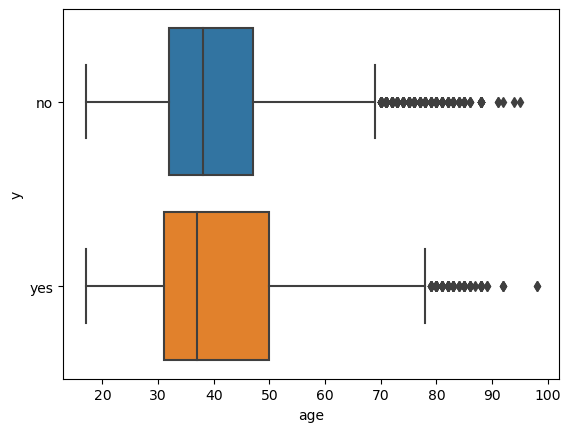

In [10]:
sns.boxplot(x = data.age, y = data.y, orient = 'h');

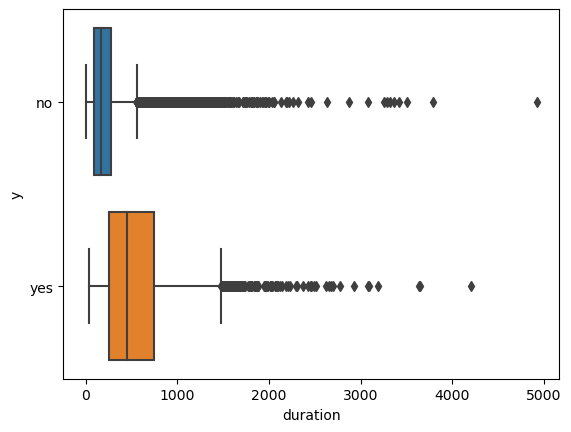

In [11]:
sns.boxplot(x = data.duration, y = data.y, orient = 'h');

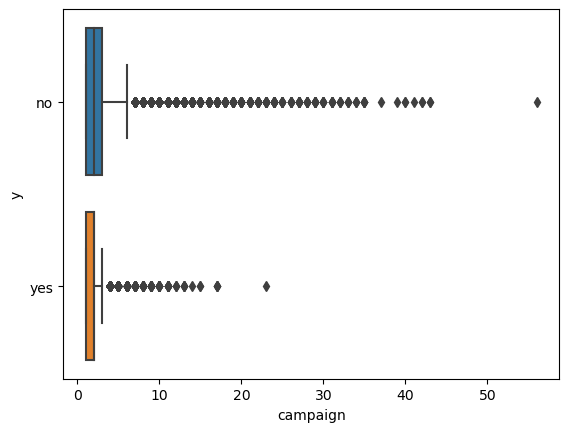

In [12]:
sns.boxplot(x = data.campaign, y = data.y, orient = 'h');

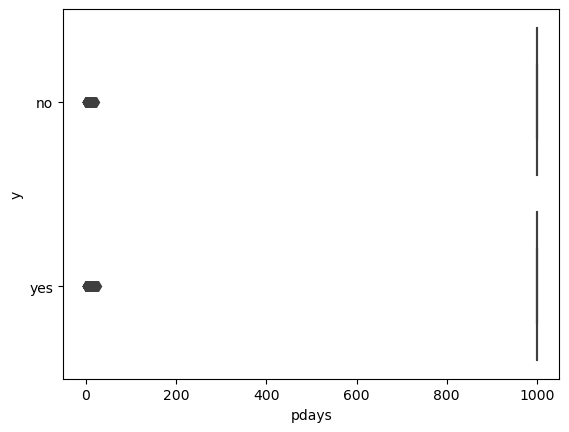

In [13]:
sns.boxplot(x = data.pdays, y = data.y, orient = 'h');

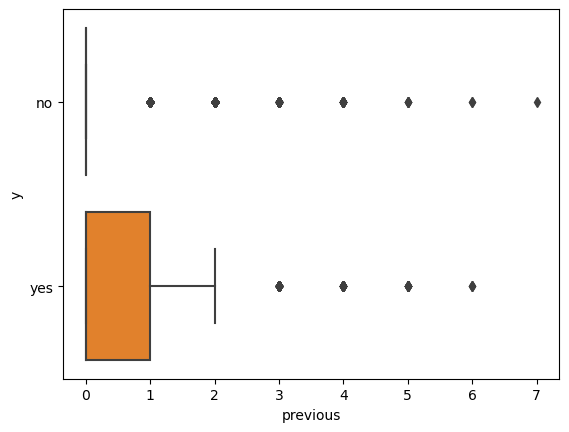

In [14]:
sns.boxplot(x = data.previous, y = data.y, orient = 'h');

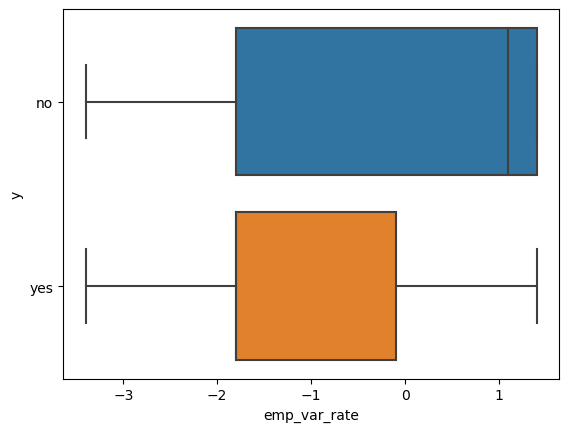

In [15]:
sns.boxplot(x = data.emp_var_rate, y = data.y, orient = 'h');

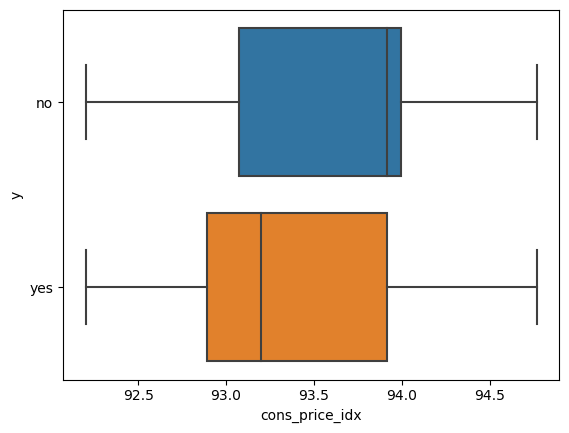

In [16]:
sns.boxplot(x = data.cons_price_idx, y = data.y, orient = 'h');

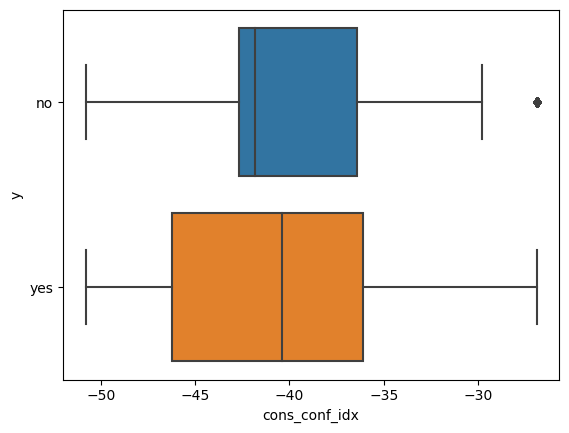

In [17]:
sns.boxplot(x = data.cons_conf_idx, y = data.y, orient = 'h');

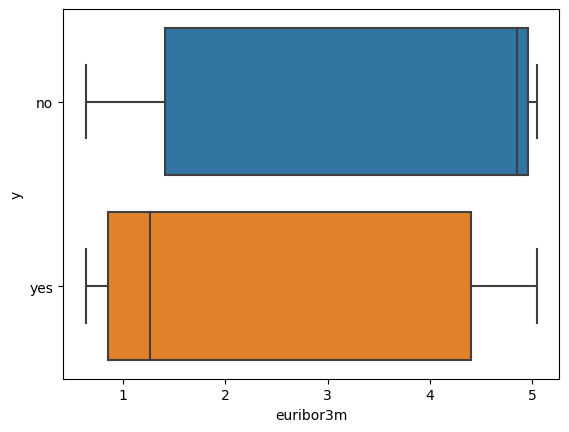

In [18]:
sns.boxplot(x = data.euribor3m, y = data.y, orient = 'h');

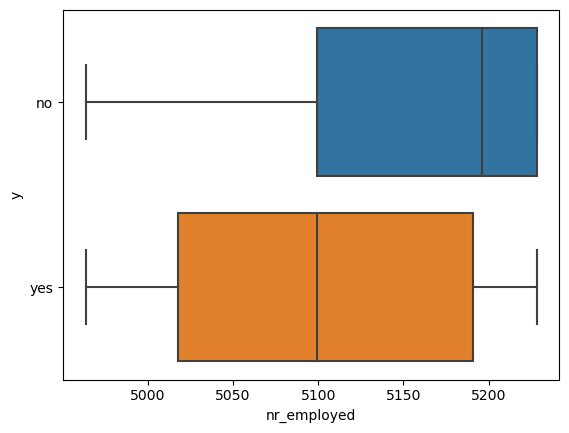

In [19]:
sns.boxplot(x = data.nr_employed, y = data.y, orient = 'h');

> We observe outliers for some of the variables. Also, the quartile ranges vary based on the target variable value for many variables.

#### Look for the category distribution in categorical columns

In [20]:
# Category distribution
data.job.value_counts(normalize = True)

admin.           0.253035
blue-collar      0.224677
technician       0.163713
services         0.096363
management       0.070992
retired          0.041760
entrepreneur     0.035350
self-employed    0.034500
housemaid        0.025736
unemployed       0.024619
student          0.021244
unknown          0.008012
Name: job, dtype: float64

In [21]:
data.marital.value_counts(normalize = True)

married     0.605225
single      0.280859
divorced    0.111974
unknown     0.001942
Name: marital, dtype: float64

In [22]:
data.education.value_counts(normalize = True)

university.degree      0.295426
high.school            0.231014
basic.9y               0.146766
professional.course    0.127294
basic.4y               0.101389
basic.6y               0.055647
unknown                0.042027
illiterate             0.000437
Name: education, dtype: float64

In [23]:
data.default.value_counts(normalize = True)

no         0.791201
unknown    0.208726
yes        0.000073
Name: default, dtype: float64

In [24]:
data.housing.value_counts(normalize = True)

yes        0.523842
no         0.452122
unknown    0.024036
Name: housing, dtype: float64

In [25]:
data.loan.value_counts(normalize = True)

no         0.824269
yes        0.151695
unknown    0.024036
Name: loan, dtype: float64

In [26]:
data.contact.value_counts(normalize = True)

cellular     0.634748
telephone    0.365252
Name: contact, dtype: float64

In [27]:
data.month.value_counts(normalize = True)

may    0.334296
jul    0.174177
aug    0.149995
jun    0.129115
nov    0.099568
apr    0.063902
oct    0.017432
sep    0.013839
mar    0.013256
dec    0.004419
Name: month, dtype: float64

In [28]:
data.day_of_week.value_counts(normalize = True)

thu    0.209357
mon    0.206711
wed    0.197485
tue    0.196416
fri    0.190031
Name: day_of_week, dtype: float64

In [29]:
data.poutcome.value_counts(normalize = True)

nonexistent    0.863431
failure        0.103234
success        0.033335
Name: poutcome, dtype: float64

> Most categorical variables have very few null values which we can keep as unknown to observe how the Keras preprocessing layers vectorize them.

In [30]:
data.y.value_counts(normalize = True)

no     0.887346
yes    0.112654
Name: y, dtype: float64

In [31]:
# Changing target variable to integer
data.y = data.y.replace('no', 0).replace('yes', 1)

In [32]:
data.y.value_counts(normalize = True)

0    0.887346
1    0.112654
Name: y, dtype: float64

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

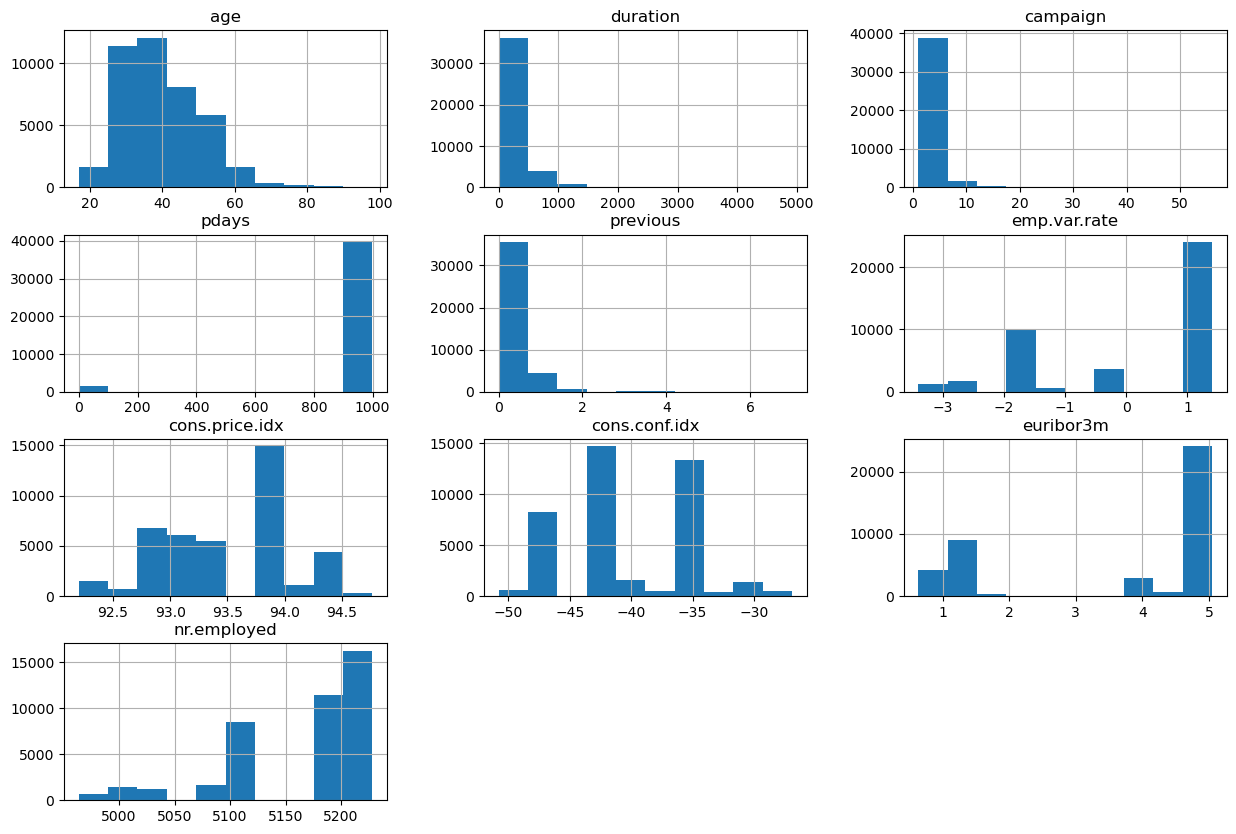

In [34]:
df.hist(figsize = (15, 10));

> We observe that age, duration, campaign and cons.conf.idx is right skewed whereas pdays and euribor3m are left skewed. The remaining variables are within acceptable standard deviations of their respective means.

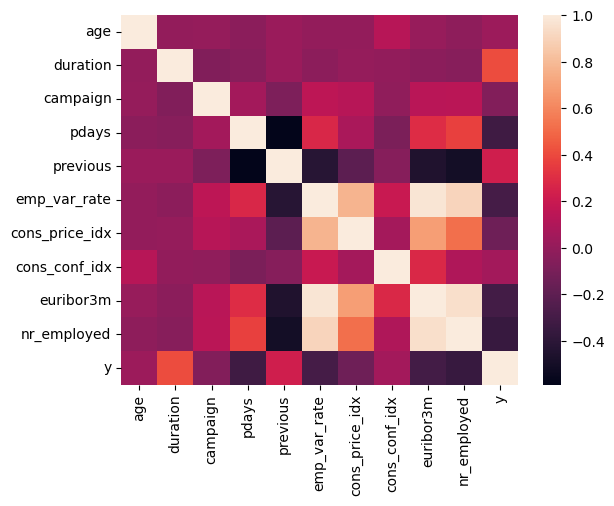

In [35]:
sns.heatmap(data.corr());

> We observe strong correlation among emp_var_rate, cons_price_idx, euribor3m and nr_employed indicating that possibly the Euribor 3 month lending rate is decided by the high/low inflation (influencing the consumer price index) to curb/promote employement (influencing the employement variation rate and the no. of people employed). Other that, there are no correlated variables.

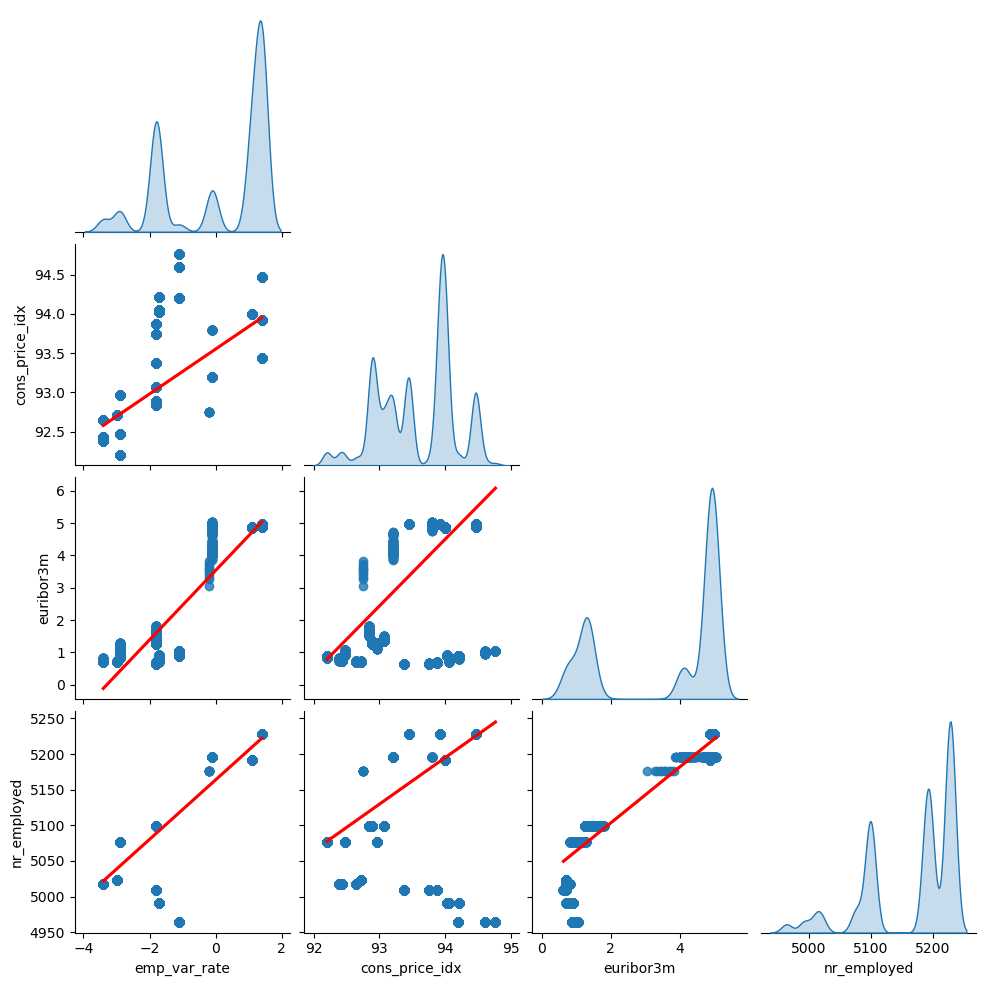

In [36]:
sns.pairplot(data[['emp_var_rate', 'cons_price_idx', 'euribor3m', 'nr_employed']],
             kind = 'reg', diag_kind = 'kde', corner = True, plot_kws = {'line_kws' : {'color' : 'red'}});

> Same is confirmed from the regression trendlines on the pairplots above.

### Seperate the training, validation, and testing datasets

In [37]:
# Using stratified sampling based on the target variable
test_data = data.sample(frac = 0.05, weights = data.groupby('y')['y'].transform('count'), random_state = 42)
x = data.drop(test_data.index)
val_data = x.sample(frac = 0.2, weights = x.groupby('y')['y'].transform('count'), random_state = 42)
train_data = data.drop(val_data.index)

print("Using %d samples for training, %d for validation and %d for testing." % (len(train_data), len(val_data), len(test_data)))

Using 33362 samples for training, 7826 for validation and 2059 for testing.


### Generating tf.data.Dataset objects for each dataframe

In [38]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop('y')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_data)
val_ds = dataframe_to_dataset(val_data)
test_ds = dataframe_to_dataset(test_data)

2023-05-26 05:03:07.009925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=88>, 'job': <tf.Tensor: shape=(), dtype=string, numpy=b'retired'>, 'marital': <tf.Tensor: shape=(), dtype=string, numpy=b'married'>, 'education': <tf.Tensor: shape=(), dtype=string, numpy=b'basic.4y'>, 'default': <tf.Tensor: shape=(), dtype=string, numpy=b'no'>, 'housing': <tf.Tensor: shape=(), dtype=string, numpy=b'no'>, 'loan': <tf.Tensor: shape=(), dtype=string, numpy=b'no'>, 'contact': <tf.Tensor: shape=(), dtype=string, numpy=b'cellular'>, 'month': <tf.Tensor: shape=(), dtype=string, numpy=b'sep'>, 'day_of_week': <tf.Tensor: shape=(), dtype=string, numpy=b'mon'>, 'duration': <tf.Tensor: shape=(), dtype=int64, numpy=127>, 'campaign': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'pdays': <tf.Tensor: shape=(), dtype=int64, numpy=999>, 'previous': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'poutcome': <tf.Tensor: shape=(), dtype=string, numpy=b'nonexistent'>, 'emp_var_rate': <tf.Tensor: shape=(), dtype=float64, numpy=-1.1>, 'co

> Each Dataset yields a tuple (input, target) where input is a dictionary of features and target is the value 0 or 1.

In [40]:
# Batching the datasets
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

### Feature preprocessing with Keras layers

In [41]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our numerical features
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

### Build the model

In [42]:
# Categorical feature encoded as string
job = keras.Input(shape = (1,), name = "job", dtype = "string")
marital = keras.Input(shape = (1,), name = "marital", dtype = "string")
education = keras.Input(shape = (1,), name = "education", dtype = "string")
default = keras.Input(shape = (1,), name = "default", dtype = "string")
housing = keras.Input(shape = (1,), name = "housing", dtype = "string")
loan = keras.Input(shape = (1,), name = "loan", dtype = "string")
contact = keras.Input(shape = (1,), name = "contact", dtype = "string")
month = keras.Input(shape = (1,), name = "month", dtype = "string")
day_of_week = keras.Input(shape = (1,), name = "day_of_week", dtype = "string")
poutcome = keras.Input(shape = (1,), name = "poutcome", dtype = "string")

# Numerical features
age = keras.Input(shape = (1,), name = "age")
duration = keras.Input(shape = (1,), name = "duration")
campaign = keras.Input(shape = (1,), name = "campaign")
pdays = keras.Input(shape = (1,), name = "pdays")
previous = keras.Input(shape = (1,), name = "previous")
emp_var_rate = keras.Input(shape = (1,), name = "emp_var_rate")
cons_price_idx = keras.Input(shape = (1,), name = "cons_price_idx")
cons_conf_idx = keras.Input(shape = (1,), name = "cons_conf_idx")
euribor3m = keras.Input(shape = (1,), name = "euribor3m")
nr_employed = keras.Input(shape = (1,), name = "nr_employed")

all_inputs = [
    job,
    marital,
    education,
    default,
    housing,
    loan,
    contact,
    month,
    day_of_week,
    poutcome,
    age,
    duration,
    campaign,
    pdays,
    previous,
    emp_var_rate,
    cons_price_idx,
    cons_conf_idx,
    euribor3m,
    nr_employed
]

# String categorical features
job_encoded = encode_categorical_feature(job, "job", train_ds, True)
marital_encoded = encode_categorical_feature(marital, "marital", train_ds, True)
education_encoded = encode_categorical_feature(education, "education", train_ds, True)
default_encoded = encode_categorical_feature(default, "default", train_ds, True)
housing_encoded = encode_categorical_feature(housing, "housing", train_ds, True)
loan_encoded = encode_categorical_feature(loan, "loan", train_ds, True)
contact_encoded = encode_categorical_feature(contact, "contact", train_ds, True)
month_encoded = encode_categorical_feature(month, "month", train_ds, True)
day_of_week_encoded = encode_categorical_feature(day_of_week, "day_of_week", train_ds, True)
poutcome_encoded = encode_categorical_feature(poutcome, "poutcome", train_ds, True)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
duration_encoded = encode_numerical_feature(duration, "duration", train_ds)
campaign_encoded = encode_numerical_feature(campaign, "campaign", train_ds)
pdays_encoded = encode_numerical_feature(pdays, "pdays", train_ds)
previous_encoded = encode_numerical_feature(previous, "previous", train_ds)
emp_var_rate_encoded = encode_numerical_feature(emp_var_rate, "emp_var_rate", train_ds)
cons_price_idx_encoded = encode_numerical_feature(cons_price_idx, "cons_price_idx", train_ds)
cons_conf_idx_encoded = encode_numerical_feature(cons_conf_idx, "cons_conf_idx", train_ds)
euribor3m_encoded = encode_numerical_feature(euribor3m, "euribor3m", train_ds)
nr_employed_encoded = encode_numerical_feature(nr_employed, "nr_employed", train_ds)

all_features = keras.layers.concatenate(
    [
        job_encoded,
        marital_encoded,
        education_encoded,
        default_encoded,
        housing_encoded,
        loan_encoded,
        contact_encoded,
        month_encoded,
        day_of_week_encoded,
        poutcome_encoded,
        age_encoded,
        duration_encoded,
        campaign_encoded,
        pdays_encoded,
        previous_encoded,
        emp_var_rate_encoded,
        cons_price_idx_encoded,
        cons_conf_idx_encoded,
        euribor3m_encoded,
        nr_employed_encoded
    ]
)

x = keras.layers.Dense(32, activation = "relu")(all_features)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics = ["accuracy"])

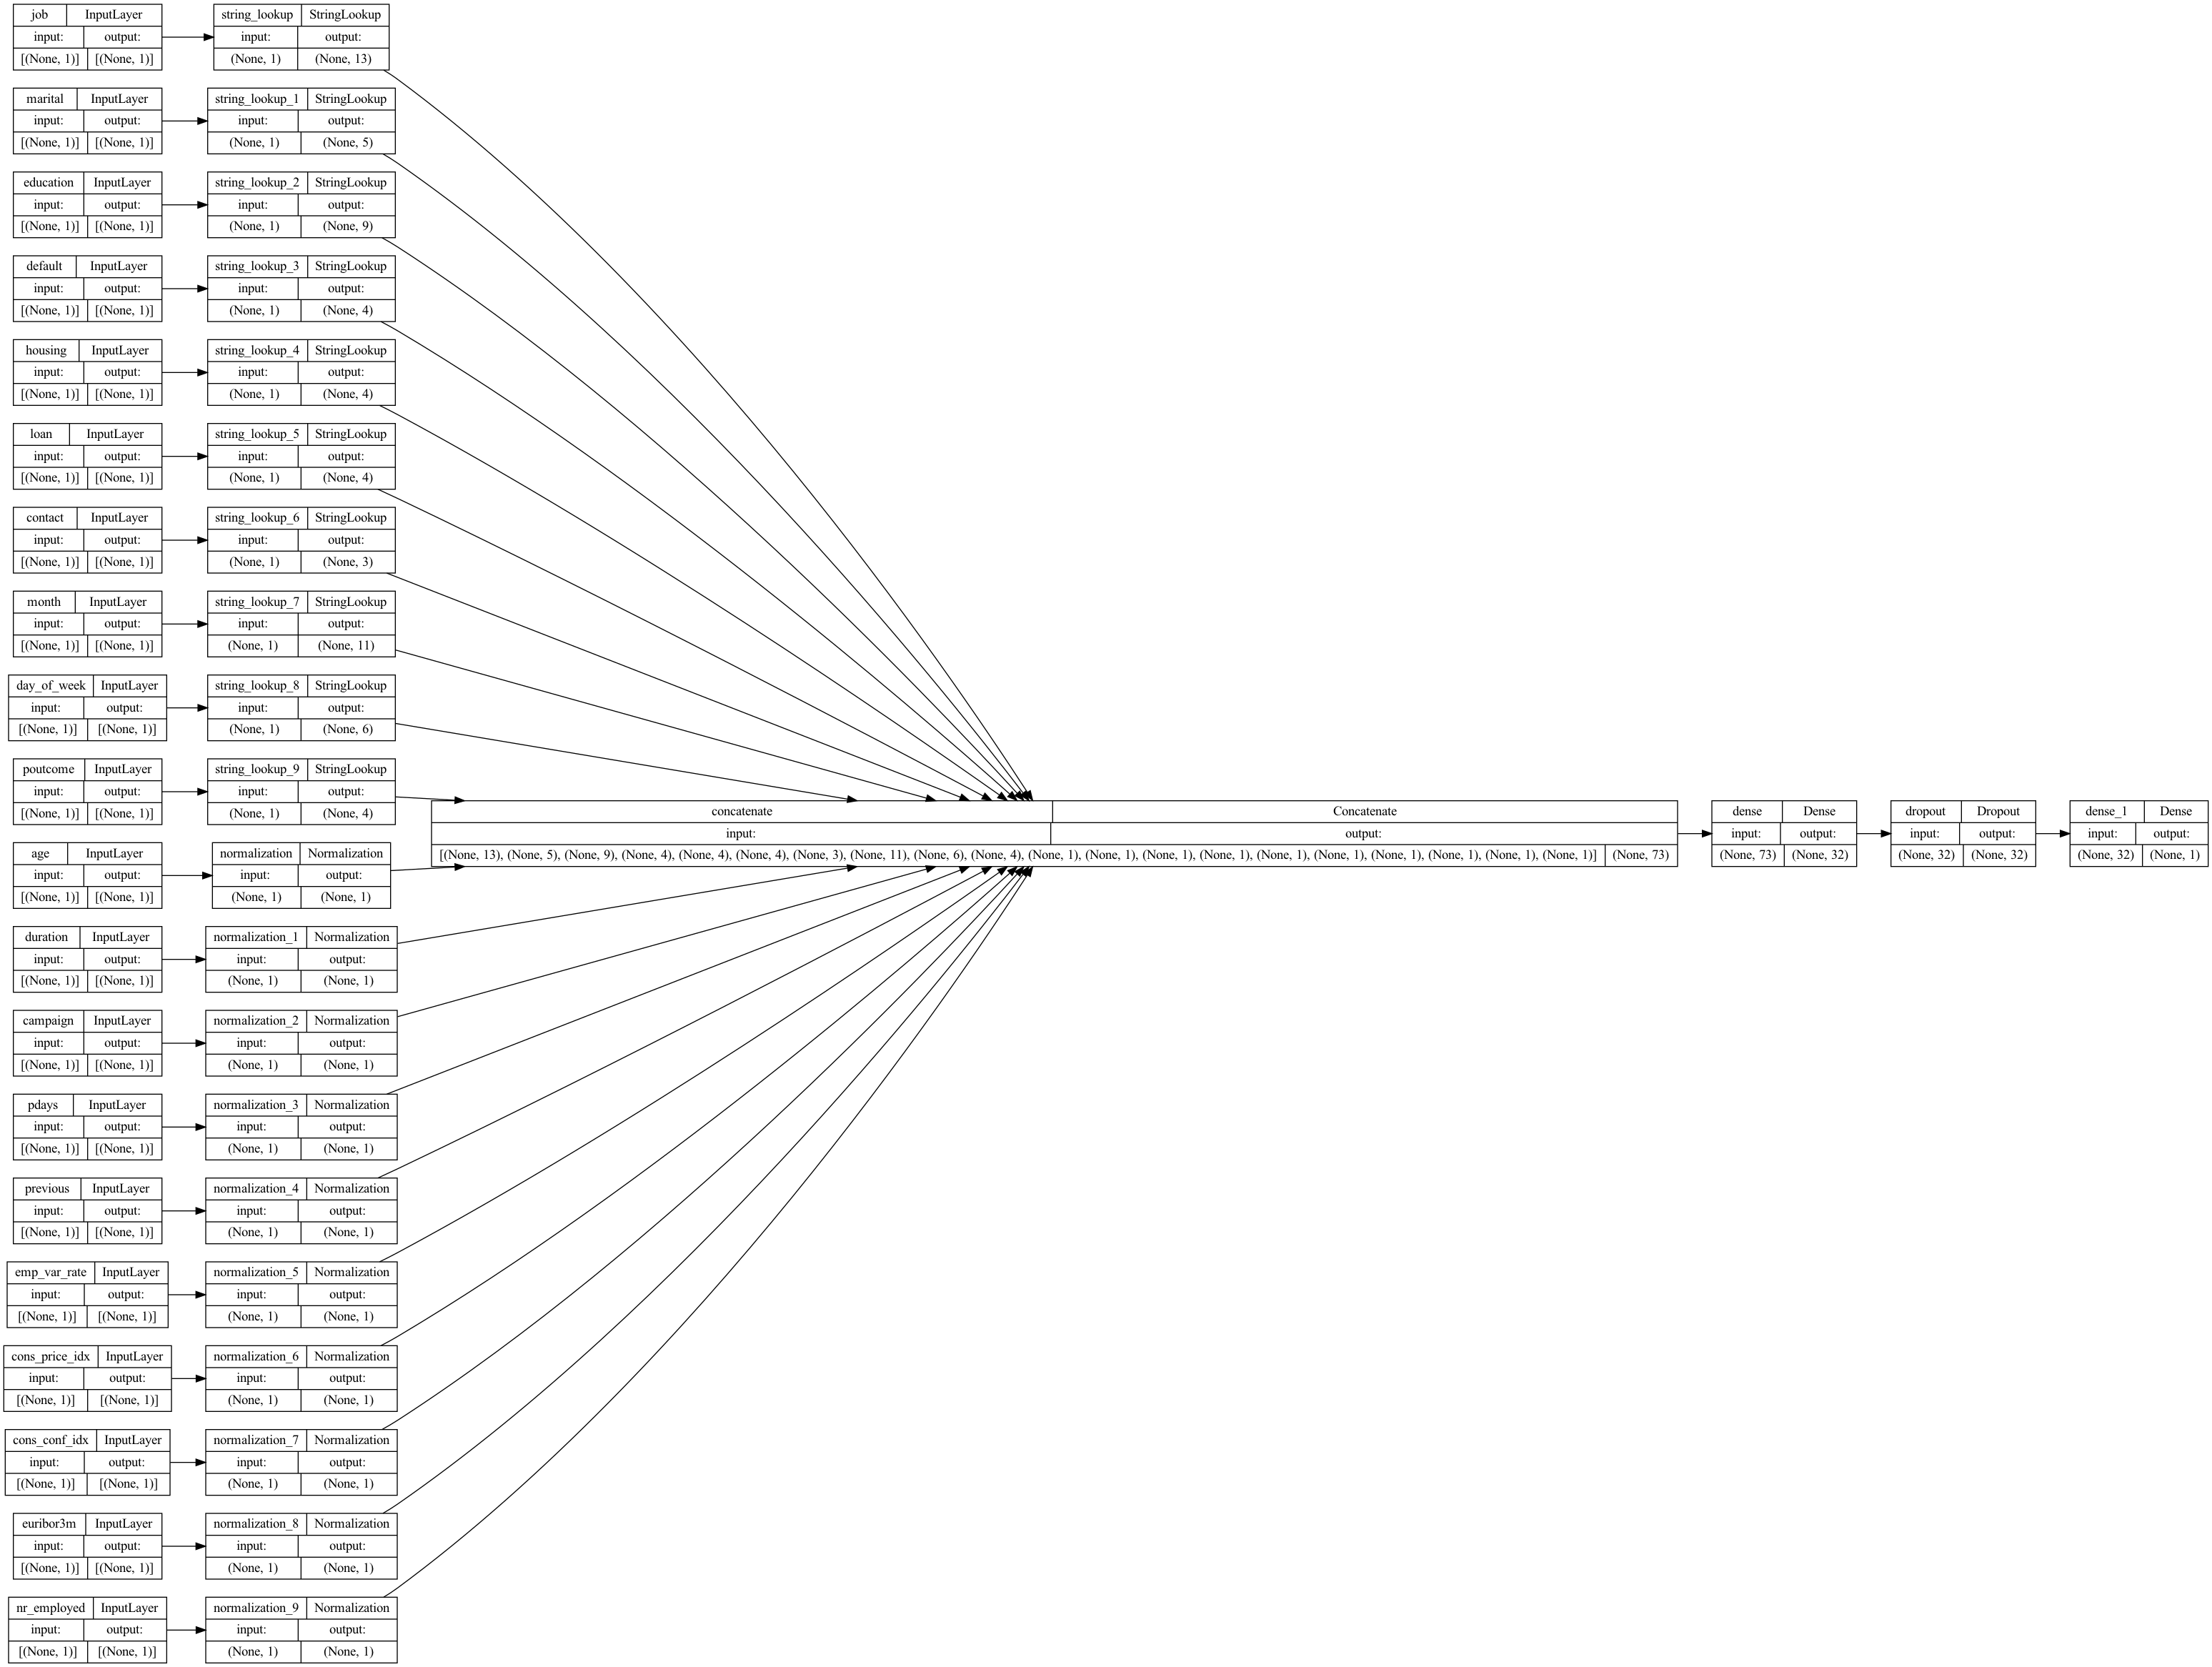

In [43]:
# Visualizing our connectivity graph
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Train the model

In [44]:
# Fit the keras model on the dataset
model.fit(train_ds, epochs = 50, validation_data = val_ds, verbose = 2)

Epoch 1/50
1043/1043 - 3s - loss: 0.2741 - accuracy: 0.8842 - val_loss: 0.1090 - val_accuracy: 0.9587 - 3s/epoch - 3ms/step
Epoch 2/50
1043/1043 - 2s - loss: 0.2202 - accuracy: 0.8975 - val_loss: 0.1082 - val_accuracy: 0.9563 - 2s/epoch - 2ms/step
Epoch 3/50
1043/1043 - 2s - loss: 0.2126 - accuracy: 0.8996 - val_loss: 0.1074 - val_accuracy: 0.9550 - 2s/epoch - 2ms/step
Epoch 4/50
1043/1043 - 2s - loss: 0.2119 - accuracy: 0.9008 - val_loss: 0.1139 - val_accuracy: 0.9540 - 2s/epoch - 2ms/step
Epoch 5/50
1043/1043 - 2s - loss: 0.2090 - accuracy: 0.9009 - val_loss: 0.1091 - val_accuracy: 0.9548 - 2s/epoch - 2ms/step
Epoch 6/50
1043/1043 - 2s - loss: 0.2074 - accuracy: 0.9034 - val_loss: 0.1064 - val_accuracy: 0.9571 - 2s/epoch - 2ms/step
Epoch 7/50
1043/1043 - 2s - loss: 0.2069 - accuracy: 0.9026 - val_loss: 0.1115 - val_accuracy: 0.9509 - 2s/epoch - 2ms/step
Epoch 8/50
1043/1043 - 2s - loss: 0.2040 - accuracy: 0.9041 - val_loss: 0.1075 - val_accuracy: 0.9536 - 2s/epoch - 2ms/step
Epoch 9/

> We observe ~95.5% validation accuracy.

### Test the model

In [46]:
# Evaluate the keras model
_, accuracy = model.evaluate(test_ds, verbose = 0)
print('Accuracy: %.2f' % (accuracy * 100))

Accuracy: 95.82


> On unseen data, the model showcases ~95.8% accuracy in predicting whether the customer would subscribe to a term deposit or not based on the customer attributes, past correspondence, marketing initiatives, and social and economic scenarios.

Additional models (Wide, Deep, and Cross Networks, Gated Residual Networks, Variable Selection Networks), TensorFlow resources (Decision Forests and TabTransformer) and Keras resources (FeatureSpace and class_weight argument for highly imbalanced classes) beyond the scope of this project can be tested to further improve the accuracy.